# RESONANCIA MAGNETICA NUCLEAR Y MEF

La Resonancia Magnética Nuclear (RMN), en especial la que se adquiere mediante Registros Geofísicos de Pozo (RGP), es una de las técnicas que han tomado un papel relevante en el análisis de las propiedades petrofísicas del medio poroso. Es de particular interés, dadas las características de la RMN, el análisis a la respuesta de la porosidad. 

RMN mide el tiempo de relajación de los núcleos de Hidrógeno dentro de un medio saturado. En general, es de interés los tiempos de relajación transversal, también conocidos como $T_2$, los cuales se relacionan directamente a la porosidad.

Este notebook, tiene el particular interés simular la respuesta de $T_2$ mediante la ecuación de Bloch-Torrey (BT) utilizando el Método de Elemento Finito (MEF) implementado en el lenguaje de Pyhton y Fenics.

# LIBRERIAS Y UTILIDADES

## Carga de Librerias

El primer paso es cargar todas las librerias que serán necesarias para realizar la simulación.
Las principales librerías son numpy, scipy, matplotlib y dolphin (FEniCs)

In [1]:
import subprocess
import platform, sys, os, shutil
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

#DEPENDENCIAS BÁSICAS
import numpy as np
import scipy
import scipy.optimize
import scipy.stats
from scipy import stats
from scipy.stats import skewnorm
from scipy.stats import uniform

#VISUALIZADORES
import plotly
%matplotlib inline
#%matplotlib notebook
import matplotlib as mpl   
import matplotlib.pyplot as plt
from matplotlib.pylab import hist, show
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

#IMPORTAR FENICS
import dolfin as FEM  
import dolfin.common.plotting as fenicsplot
import mshr

#IMPORTAR OTROS MALLADORES
import pygmsh as pg 
import meshio 

#OTRAS DEPENDENCIAS

from IPython.display import clear_output, display, Math, Latex
from random import seed, uniform, randint
from tqdm import tqdm
import time

#VERIFICAR VERSIONES

print('numpy       version {}'.format( np.__version__))
print('scipy       version {}'.format(scipy.__version__))
print('plotly      version {}'.format(plotly.__version__))
print('matplotlib  version {}'.format(mpl.__version__))
print('dolfin      version {}'.format(FEM.__version__))
print('pygmsh      version {}'.format(pg.__version__))
print('meshio      version {}'.format(meshio.__version__))
print('gmsh        version {}'.format(subprocess.Popen(
     ('gmsh', '--version'),
     stdout=subprocess.PIPE,
     stderr=subprocess.STDOUT).communicate()[0][:-1].decode('utf-8')))

numpy       version 1.21.5
scipy       version 1.7.3
plotly      version 5.6.0
matplotlib  version 3.5.1
dolfin      version 2019.1.0
pygmsh      version 6.0.5
meshio      version 5.2.2
gmsh        version 4.6.0


## Descarga / Lee FinneyPack4021

En algunos casos, se utilizarán los datos de un empaquetado de esferas denominado "Finney Pack". Estos datos son unos de los primeros empaquetamientos de esferas utilizados como representativos de un medio poroso.

In [2]:
#Descarga FinneyPack
#!wget https://www.digitalrocksportal.org/media/projects/47/origin/310/images/FinneyPack4021.txt

#Remueve FinneyPack
#!rm FinneyPack4021.txt.*

#Lee el encabezado de FinneyPack
!head FinneyPack4021.txt

     1   -0.324554   0.081522  -0.452144
     2    0.139446  -1.232478   0.985858
     3    1.641446  -0.078478  -0.876144
     4   -1.182554   0.557522   1.385856
     5    1.713446   0.143522   1.107856
     6   -1.874554  -0.956478   0.277856
     7    0.687446   1.669524  -1.132144
     8    0.467446   1.679522   1.389856
     9    0.799446  -1.950478  -0.794144
    10   -1.420554   1.755522  -0.566142


# RESOLVIENDO BT CON FEniCS

### FID

El experimiento más sencillo de RMN es la Caída de Inducción Libre o FID (Free Induction Decay) en un caso ideal, es decir, sin presencia de efectos y ruido del medio.
FID hace referencia al tiempo en el que, después de aplicado un pulso y polarizado los núcleos de H en dirección al campo $B_1$, los núcleos comienzan a relajar hacia su estado de equilibrio. En otras palabras, con FID observamos la magnetización transversal $m_T$ y el tiempo ($T_2$) de la muestra.


In [50]:
#FID Free Induction Decay
class fid:
    def __init__(self, model, dt    = 1.e-2,
                              tf    = 4.,
                              G     = 0.,
                              g     = (1., 0.),
                              theta = 0.5,
                ):
        self._model = model
        self._dt    = dt
        self._tf    = tf
        self._G     = G
        self._g     = g
        self._theta = theta

        self._nt     = int(np.round(self._tf/self._dt)) + 1
        self._t_arr  = np.linspace(0., self._tf, self._nt)

        self._model.set_sequence(self)

    # PULSED-GRADIENT TIME-PROFILE
    def pulse_profile(self, t):
        return 1.

    # EXTERNAL FIELD
    def phase_encode(self):
        return  FEM.Expression("f*(G*(gx*x[0] + gy*x[1]))",
                             f      = self.pulse_profile(0.),
                             G      = self._G,
                             gx     = self._g[0],
                             gy     = self._g[1],
                             domain = self._model.mesh(),
                             degree = 3,
                              )

    def run(self, point_eval= None):
        # Solution arrays
        mx_out = np.zeros(self._nt)
        my_out = np.zeros(self._nt)

        mx_out[0] = FEM.assemble(self._model.mx()*self._model.dx())
        my_out[0] = FEM.assemble(self._model.my()*self._model.dx())

        if point_eval:
            point_e    = np.zeros(self._nt)
            point_e[0] = np.arctan2(self._model.my()(point_eval),
                                    self._model.mx()(point_eval),
                                   )

        for i, t in enumerate(self._t_arr[1:]):
            self._model.mn().vector()[:] = self._model.m().vector()
            self._model.solver().solve(self._model.problem(), self._model.m().vector())

            mx_out[i] = FEM.assemble(self._model.mx()*self._model.dx())
            my_out[i] = FEM.assemble(self._model.my()*self._model.dx())

            if point_eval:
                point_e[i] = np.arctan2(self._model.my()(point_eval),
                                          self._model.mx()(point_eval),
                                         )

        if point_eval:
            return mx_out, my_out, point_e
        else:
            return mx_out, my_out

    def model(self):
        return self._model

    def dt(self):
        return self._dt

    def tf(self):
        return self._tf

    def G(self):
        return self._G

    def g(self):
        return self._g

    def theta(self):
        return self._theta

    def nt(self):
        return self._nt

    def t_arr(self):
        return self._t_arr

### NMR - FEniCS

In [51]:
#NMR Laboratory
class NMRlab:
    # READ-IN THE MESH AND MESHFN, REDEFINE MEASURES
    def __init__(self, mesh, meshfn):
        
        # READ MESH, MESHFN
        self._mesh = mesh
        self._meshfn = meshfn

        # REDEFINE MEASURES
        self._dx = FEM.Measure('dx', domain= self._mesh,
                                     subdomain_data= self._meshfn,
                              )
        self._ds = FEM.Measure('ds', domain= self._mesh,
                                     subdomain_data= self._meshfn,
                              )

    # SET THE PHYSICAL PARAMETERS FOR THE MODEL
    def set_physical_parameters(self, B0   = 1.e-2,
                                      rho  = 4.e-5,
                                      D    = 6.e-8,
                                      T2   = 1.e+0,
                                      T1   = 1.e+0,
                                      gamma= 267.5e+6,
                                      temp = 3.0315e+2,
                               ):
        # ASSERT THE MESHFN AND RHO TO BE COMPATIBLE
        assert self._meshfn.array().max() == np.size(rho) - 1

        # PHYSICAL SETUP
        self._rho = rho
        self._B0  = B0
        self._D   = D       
        self._T2  = T2      
        self._T1  = T1      
        self._gamma = gamma 
        self._temp  = temp

        # CALCULATE THE SAT. MAGNETIZATION WATER
        AVOGADRO_NUMBER  = 6.0220e23
        WATER_MOL_WEIGHT = 18.0153e-3 
        WATER_DENSITY    = 9.9700e+2  
        proton_density   = (2.*AVOGADRO_NUMBER*WATER_DENSITY /
                            WATER_MOL_WEIGHT)
        HPLANCK = 6.626e-34
        KBOLTZ  = 1.380e-23

        self._msat = (proton_density*self._B0*
                      np.power(self._gamma*HPLANCK, 2)/
                      4.*KBOLTZ*self._temp)

        self._volume= self.compute_volume()
        self._surface_area = self.compute_surface_area()
        self._rho_avg = self.compute_rhoavg()

    def set_sequence(self, sequence):
        # PULSE SEQUENCE
        self._sequence = sequence
        self.setup()
        
    #START FENICS TO SOLVE BLOCH-TORREY EQUATION
    def setup(self):
        # SETUP: FEM SPACES, FORMS, ETC...
        FEM.parameters['form_compiler']['optimize']     = True
        FEM.parameters['form_compiler']['cpp_optimize'] = True

        # DEFINING FUNCTION SPACES
        self._P = FEM.FiniteElement('P', self._mesh.ufl_cell(), 1) #pendiente
        self._V = FEM.FunctionSpace(self._mesh, FEM.MixedElement(
                                                 (self._P, self._P,)
                                                                )
                                   )

        # THE TEST FUNCTIONS
        u, v = FEM.TestFunctions(self._V)

        # THE SOLUTIONS
        self._m  = FEM.Function(self._V, name= 'm' )
        self._mn = FEM.Function(self._V, name= 'mn')

        # CALCULATE THE EQUILIBRIUM MAGNETISATION
        self._eq_mag, self._eq_integral = self.calculate_equilibrium_magnetisation()

        # CREATE INITIAL CONDITIONS
        self.set_init_condition()

        # SPLIT THE 'VECTOR-VALUED' FUNCTIONS INTO 'COMPONENT-VALUED' FUNCTIONS
        self._mx, self._my = FEM.split(self._m)

        mxn, myn = FEM.split(self._mn)

        mxnt = self._sequence.theta()*self._mx + \
                (1. - self._sequence.theta())*mxn
        mynt = self._sequence.theta()*self._my + \
                (1. - self._sequence.theta())*myn

        # GET THE PHASE ENCODING FIELD
        self._fG   = self._sequence.phase_encode()
        self._fG.f = self._sequence.pulse_profile(0.)

        # THE VARIATIONAL PROBLEM
        dt    = FEM.Constant(1./self._sequence.dt())
        theta = FEM.Constant(self._sequence.theta())
        gamma = FEM.Constant(self._gamma)
        T2    = FEM.Constant(1./self._T2)
        D     = FEM.Constant(self._D)

        L1 = dt*(self._mx-mxn)*u*self._dx - \
             gamma*self._fG*mynt*u*self._dx + \
             T2*mxnt*u*self._dx + \
             D*FEM.dot(FEM.grad(mxnt), FEM.grad(u))*self._dx

        L2 = dt*(self._my-myn)*v*self._dx + \
             gamma*self._fG*mxnt*v*self._dx + \
             T2*mynt*v*self._dx + \
             D*FEM.dot(FEM.grad(mynt), FEM.grad(v))*self._dx

        if np.size(self._rho) == 1:
            L1 += FEM.Constant(self._rho)*mxnt*u*self._ds
            L2 += FEM.Constant(self._rho)*mynt*v*self._ds
        elif np.size(self._rho) > 1:
            for i, rho in enumerate(self._rho):
                L1 += FEM.Constant(rho)*mxnt*u*self._ds(i)
                L2 += FEM.Constant(rho)*mynt*v*self._ds(i)

        self._L = L1 + L2

        # NONLINEAR PROBLEM SETUP
        dm = FEM.TrialFunction(self._V)
        a = FEM.derivative(self._L, self._m, dm)
        self._problem = self.BTInterface(a, self._L)

        self._solver = FEM.NewtonSolver()
        self._solver.parameters['linear_solver'] = 'lu'
        self._solver.parameters['convergence_criterion'] = 'incremental'
        self._solver.parameters['relative_tolerance'] = 1e-6

    def calculate_equilibrium_magnetisation(self):
        # Solve the steady-state for the longitudinal magnetisation
        V = self._V.sub(0).collapse()

        u = FEM.TrialFunction(V)
        v = FEM.TestFunction(V)

        DT1 = FEM.Constant(self._D*self._T1)
        a = DT1*(FEM.dot(FEM.grad(u), FEM.grad(v)) + u*v)*self._dx
        if np.size(self._rho) == 1:
            a += FEM.Constant(self._rho)*u*v*self._ds
        elif np.size(self._rho) > 1:
            for i, rho in enumerate(self._rho):
                a += FEM.Constant(rho)*u*v*self._ds(i)

        L = FEM.Constant(self._msat)*v*self._dx

        # Compute solution
        m = FEM.Function(V)
        FEM.solve(a == L, m)
        
        return m, FEM.assemble(m*self._dx)

    # UNIFORM INITIAL CONDITIONS
    def set_init_condition(self):
        vertex2dof = FEM.vertex_to_dof_map(self._V)
        m_local = self._m.vector().get_local()
        meq_local = self._eq_mag.vector().get_local()

        for i in range(self._mesh.coordinates().shape[0]):
            m_local[vertex2dof[2*i+0]] = meq_local[int(round(vertex2dof[2*i]/2))]
            m_local[vertex2dof[2*i+1]] = 0.

        self._m.vector().set_local(m_local)
        self._m.vector().apply('insert')
        #self._mn.vector().set_local(m_local)
        #self._mn.vector().apply('insert')

    # RUN
    def run(self, point_eval= None):
        return self._sequence.run(point_eval= point_eval)

    # CALCULATE THE MESH VOLUME
    def compute_volume(self):
        volume = 0.
        for cell in FEM.cells(self._mesh):
            volume += cell.volume()
        return volume
    
    def compute_surface_area(self):
        bmesh = FEM.BoundaryMesh(self._mesh, 'exterior')
        area = 0.
        for cell in FEM.cells(bmesh):
            area += cell.volume()
        return area
    
    def compute_rhoavg(self):
        return FEM.assemble(self._rho*self._ds)/self.compute_surface_area()

    # CLASS FOR INTERFACING WITH THE NEWTON SOLVER
    class BTInterface(FEM.NonlinearProblem):
        def __init__(self, a, L):
            FEM.NonlinearProblem.__init__(self)
            self.a = a
            self.L = L
        def F(self, b, x):
            FEM.assemble(self.L, tensor= b)
        def J(self, A, x):
            FEM.assemble(self.a, tensor= A)

    # ACCESS _mesh
    def mesh(self):
        return self._mesh

    # ACCESS _meshfn
    def meshfn(self):
        return self._meshfn

    # ACCESS _dx
    def dx(self):
        return self._dx

    # ACCESS _ds
    def ds(self):
        return self._ds

    # ACCESS _B0
    def B0(self):
        return self._B0

    # ACCESS _rho
    def rho(self):
        return self._rho

    # ACCESS _D
    def D(self):
        return self._D

    # ACCESS _T2
    def T2(self):
        return self._T2

    # ACCESS _T1
    def T1(self):
        return self._T1

    # ACCESS _gamma
    def gamma(self):
        return self._gamma

    # ACCESS _fG
    def fG(self):
        return self._fG

    # ACCESS _temp
    def temp(self):
        return self._temp

    # ACCESS _msat
    def msat(self):
        return self._msat

    # ACCESS _volume
    def volume(self):
        return self._volume

    # ACCESS _surface_area
    def surface_area(self):
        return self._surface_area

    # ACCESS _rho_avg
    def rho_avg(self):
        return self._rho_avg

    # ACCESS _sequence
    def sequence(self):
        return self._sequence

    # ACCESS _P
    def P(self):
        return self._P

    # ACCESS _V
    def V(self):
        return self._V

    # ACCESS _m
    def m(self):
        return self._m

    # ACCESS _mn
    def mn(self):
        return self._mn

    # ACCESS _eq_mag
    def eq_mag(self):
        return self._eq_mag

    # ACCESS _eq_integral
    def eq_integral(self):
        return self._eq_integral

    # ACCESS _mx
    def mx(self):
        return self._mx

    # ACCESS _my
    def my(self):
        return self._my

    # ACCESS _L
    def L(self):
        return self._L

    # ACCESS _problem
    def problem(self):
        return self._problem

    # ACCESS _solver
    def solver(self):
        return self._solver

## Otras Utilidades

In [52]:
#CALCULA MT NORMALIZADA
def calculate_T2(mx, my, model, n= 1):
    mt  = np.sqrt(np.power(mx, 2) + np.power(my, 2))
    mt /= np.amax(mt)
    return mt

#CALCULA T2
def fit_T2(mt, t_arr, n= 1):
    T2star = scipy.optimize.curve_fit(lambda t, T: np.exp(-t/T),
                                       model.sequence().t_arr()[::n], mt[::n])
    return T2star[0][0]

# PORO CIRCULAR

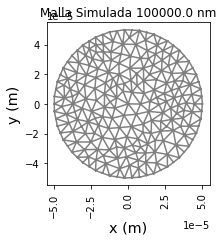

In [5]:
def mesh_c(size= 1., mesh_res= 10, outer_radius= 0.5):  
    domain  = mshr.Circle(FEM.Point((0., 0.)), outer_radius,)
    mesh    = mshr.generate_mesh(domain, mesh_res)
    mesh.scale(size)
    return mesh

pore_size = 100.e-6
mesh = mesh_c(size= pore_size, mesh_res= 10,)

#meshfn = FEM.MeshFunction("size_t", mesh, mesh.topology().dim()-1)
meshfn = FEM.MeshFunction("size_t", mesh, mesh.topology().dim()-1)
meshfn.set_all(0)

class Boundary(FEM.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary

active_boundary = Boundary()
active_boundary.mark(meshfn, 0)

fig, ax = plt.subplots(figsize= (3, 3))
FEM.plot(mesh)
plt.title('Malla Simulada {:.1f} nm'.format(1.e9*pore_size), fontsize= 'large')
plt.xlabel('x (m)', fontsize= 'x-large')
plt.ylabel('y (m)', fontsize= 'x-large')
plt.xticks(rotation= 90.,)
plt.show()

In [6]:
#Coordenadas de los nodos
mesh_points = mesh.coordinates()
# Nodos en la superficie
mesh_points_obs = mesh_points[0:]

In [15]:
model_c = NMRlab(mesh, meshfn)

rho = 18.9e-6
B0  = 1.e-2
D   = 3.e-9
T2  = 1.e-3
T1  = 1.

dt = 0.1e-3
tf = 20.e-3

model_c.set_physical_parameters(rho = rho, B0  = B0, D   = D, T2  = T2, T1  = T1,)

sequence = fid(model_c, dt= dt, tf= tf,)

mx_c, my_c, point_e = model_c.run(point_eval = (0., 0.))
#mx_c, my_c = model_c.run()

Solving linear variational problem.
Newton iteration 0: r (abs) = 4.420e-44 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
Newton solver finished in 1 iterations and 1 linear solver iterations.
Newton iteration 0: r (abs) = 3.999e-44 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
Newton solver finished in 1 iterations and 1 linear solver iterations.
Newton iteration 0: r (abs) = 3.617e-44 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
Newton solver finished in 1 iterations and 1 linear solver iterations.
Newton iteration 0: r (abs) = 3.273e-44 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
Newton solver finished in 1 iterations and 1 linear solver iterations.
Newton iteration 0: r (abs) = 2.961e-44 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
Newton solver finished in 1 iterations and 1 linear solver iterations.
Newton iteration 0: r (abs) = 2.679e-44 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
Newton solver finished in 1 itera

Newton iteration 0: r (abs) = 1.325e-47 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
Newton solver finished in 1 iterations and 1 linear solver iterations.
Newton iteration 0: r (abs) = 1.199e-47 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
Newton solver finished in 1 iterations and 1 linear solver iterations.
Newton iteration 0: r (abs) = 1.084e-47 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
Newton solver finished in 1 iterations and 1 linear solver iterations.
Newton iteration 0: r (abs) = 9.810e-48 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
Newton solver finished in 1 iterations and 1 linear solver iterations.
Newton iteration 0: r (abs) = 8.875e-48 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
Newton solver finished in 1 iterations and 1 linear solver iterations.
Newton iteration 0: r (abs) = 8.030e-48 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
Newton solver finished in 1 iterations and 1 linear solver iterations

Newton iteration 0: r (abs) = 5.934e-50 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
Newton solver finished in 1 iterations and 1 linear solver iterations.
Newton iteration 0: r (abs) = 5.369e-50 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
Newton solver finished in 1 iterations and 1 linear solver iterations.
Newton iteration 0: r (abs) = 4.857e-50 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
Newton solver finished in 1 iterations and 1 linear solver iterations.
Newton iteration 0: r (abs) = 4.394e-50 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
Newton solver finished in 1 iterations and 1 linear solver iterations.
Newton iteration 0: r (abs) = 3.975e-50 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
Newton solver finished in 1 iterations and 1 linear solver iterations.
Newton iteration 0: r (abs) = 3.596e-50 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
Newton solver finished in 1 iterations and 1 linear solver iterations

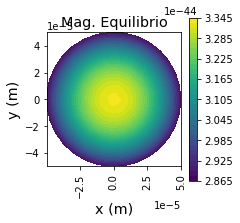

In [16]:
fig, ax = plt.subplots(figsize= (3, 3))     
plt.title('Mag. Equilibrio', fontsize= 'x-large')
plt.xlabel('x (m)', fontsize= 'x-large')
plt.ylabel('y (m)', fontsize= 'x-large')
plt.xticks(rotation= 90.)
    
plt.grid(False)
FEM.plot(model_c._eq_mag)
plt.colorbar(FEM.plot(model_c._eq_mag))

#FEM.plot(mesh)
#FEM.plot(model_c._m)

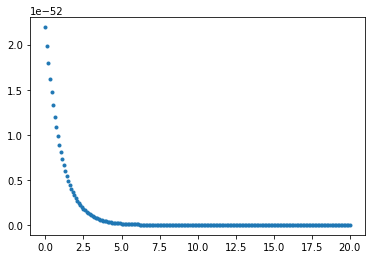

In [17]:
#t_fine = np.linspace(0., model_c.sequence().tf(), np.size(mx_c))
t_fine = model_c.sequence().t_arr()
plt.plot(1.e3*t_fine, mx_c, '.')

#print(model_c.sequence().nt())
#print(np.size(model_c.sequence().t_arr()))

In [24]:
print(model_c.eq_integral())
mt_c  = np.sqrt(np.power(mx_c, 2) + np.power(my_c, 2))
np.amax(mt_c)

2.4240746491068082e-52


2.1930554546917323e-52

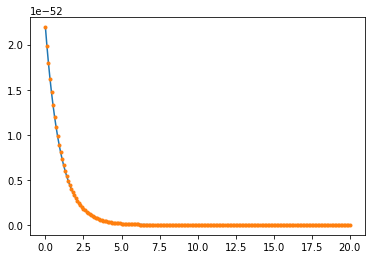

In [19]:
#Comparar mx y mt
plt.plot(1.e3*t_fine, mx_c)
plt.plot(1.e3*t_fine, mt_c,'.')
plt.show()

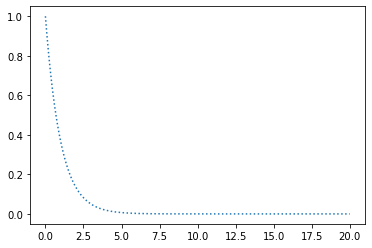

In [27]:
#Normaliza mt
mt_cn = mt_c/np.amax(mt_c)

plt.plot(1.e3*t_fine, mt_cn,':')
plt.show()

Error máximo en el calculo de mt: 0.02870%.


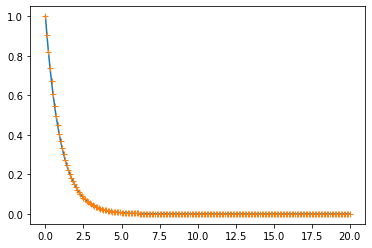

In [28]:
#Solucion analítica

T2_total_c = 1./((1./model_c.T2())+(model_c.rho_avg()*(model_c.surface_area()/model_c.volume())))

T2_analitic = np.exp(-t_fine/T2_total_c)

mt_c_error_per =  1.e2*np.abs(mt_cn - np.exp(-model_c.sequence().t_arr()/T2_total_c))
print('Error máximo en el calculo de mt: {:.5f}%.'.format(mt_c_error_per.max()))

plt.plot(1.e3*t_fine, T2_analitic)
plt.plot(1.e3*t_fine, mt_cn, '+')
plt.show()

In [29]:
#Ruido en los datos

sigma = max(abs(mt_cn))*0.01

# Compute the data with normal noise
data_c = mt_cn + scipy.stats.norm.rvs(scale=sigma,size=len(mt_cn))

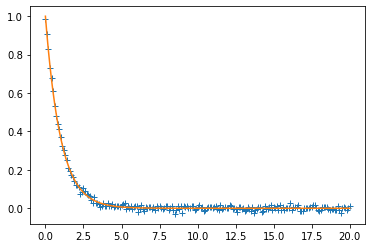

In [30]:
plt.plot(1.e3*t_fine, data_c,'+')
plt.plot(1.e3*t_fine, T2_analitic)
plt.show()

In [ ]:
tol = 0.001 # avoid hitting points outside the domain
y = np.linspace(-1 + tol, 1 - tol, 101)
points = [(0, y_) for y_ in y] # 2D points
w_line = np.array([model_c._eq_mag(point) for point in points])
plt.plot(y, w_line)
plt.grid(True)

In [ ]:
vtkfile = FEM.File('NMR_FID_C/eq_mag.pvd')
vtkfile << model_c._eq_mag

np.savetxt('mx_c.csv', (mx_c), delimiter= ',')

# $m_T$ DIFERENTES POROS

## CREA LAS FUNCIONES A UTILIZAR

In [34]:
def mesh_c1(size= 1.):                                 
    domain  = mshr.Circle(FEM.Point((0., 0.)), 0.5)
    mesh1   = mshr.generate_mesh(domain, 5 )
    mesh1.scale(size)

    meshfn1 = FEM.MeshFunction("size_t", mesh1, mesh1.topology().dim()-1)
    meshfn1.set_all(0)

    class Boundary(FEM.SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary

    active_boundary = Boundary()
    active_boundary.mark(meshfn1, 0)
    
    return mesh1, meshfn1

def mt_signal(mesh1, meshfn1):
    model_c1 = NMRlab(mesh1, meshfn1)
    model_c1.set_physical_parameters(rho= 21.e-6, B0= 1.76e-2, D= 1.8e-9, T2= 1.5e-3, T1= 1.e-3)
    sequence = fid(model_c1, dt= 1.e-4, tf= 10.e-3,)
    mx_c1, my_c1 = model_c1.run()
    
    mt_c1 = calculate_T2(mx_c1, my_c1, model_c1)
    
    return mt_c1 #mx_c1

def W(r, dist, mu, sigm,):
    return skewnorm.pdf(r, dist, mu, sigm)

## CREA UN ARRAY DE TAMAÑOS RANDOM

In [20]:
#1.e-6 equivale a 1000nm es decir, 1 um, por lo que la lista de tamaños va de 1um a 10um
#Primero se creó un array aleatorio, el cual se guardó para tener un registro controlado
#sizes_rand= stats.uniform(0.001e-3, 100.e-3).rvs(10000)

In [23]:
#sizes_rand

array([0.06800173, 0.08537922, 0.0786877 , ..., 0.01441594, 0.00407559,
       0.06759547])

In [24]:
np.savetxt('sizes_rand.txt', sizes_rand, delimiter=',')

### CARGA EL TXT DE TAMAÑOS RANDOM

In [35]:
sizes_c1 = np.loadtxt('sizes_rand.txt', delimiter=',')

(array([13., 13., 11., 11., 11.,  8.,  7., 13., 15., 16., 13., 12.,  6.,
        10., 12.,  9.,  9.,  9.,  6., 10.,  5.,  5.,  7., 13.,  6.,  8.,
         9., 12.,  6.,  9., 12., 11.,  7.,  9., 12.,  6., 12.,  3., 14.,
        11., 12.,  9., 14.,  9., 10., 12., 10.,  9., 10., 13., 14.,  8.,
        11., 13.,  6.,  8.,  8., 11.,  5., 15.,  7.,  9., 12., 12.,  9.,
        12., 12.,  8.,  7., 14.,  9., 10., 11., 11., 10.,  9.,  9.,  6.,
         9.,  9., 13., 11., 17., 10., 14., 11., 16., 10., 12., 12., 10.,
         8., 10.,  6., 10.,  8.,  9.,  7.,  9.,  8., 11.,  9., 12., 12.,
         8., 11., 12.,  9., 11., 10.,  7.,  6., 11., 14.,  9., 10.,  9.,
         8.,  9., 12., 11., 10., 11., 15.,  8., 21.,  5.,  5., 14.,  7.,
        11.,  5., 12.,  7., 14., 14.,  6., 12.,  5.,  5., 12.,  9.,  6.,
         7., 13., 14., 15., 10., 11.,  5.,  9., 11.,  9., 12., 10., 10.,
        13., 13., 13., 11.,  8., 11., 11.,  9.,  6.,  8., 15.,  5.,  4.,
         9., 13.,  7.,  9., 12., 11., 10.,  8., 13.

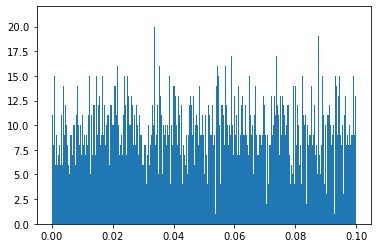

In [36]:
plt.hist(sizes_c1, bins= 1000)

## CALCULA $m_t$

In [38]:
#mt_normalizada
mt_r1 = {}

for i, size in enumerate(sizes_c1):
    mesh1, meshfn1 = mesh_c1(size)
    mt_r1[i] = mt_signal(mesh1, meshfn1)

In [39]:
np.size(mt_r1[0])

101

## GUARDAR $m_t$ EN CSV

In [40]:
import pandas as pd
import csv

In [41]:
df = [pd.DataFrame({ k : v }) for k, v in mt_r1.items()]
df = pd.concat(df, axis=1)

df.to_csv('mt_r1.csv', index=False) 

### CREA UN ARRAY DE TIEMPOS

In [42]:
t_fine_1 = np.linspace(0., 10, np.size(mt_r1[0]))

In [43]:
df = df.assign(t_f = t_fine_1)

### GUARDAR CSV MODIFICADO

In [44]:
df.to_csv('mod_mt_r1.csv', index=False) 

## CARGAR $m_t$

In [45]:
mt_load= pd.read_csv('mod_mt_r1.csv', header=0, encoding= 'unicode_escape')

In [46]:
mt_load.describe()

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,t_f
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,...,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.153271,0.153271,0.153271,0.153271,0.153271,0.153271,0.153271,0.153271,0.153271,0.153271,...,0.153271,0.153271,0.153271,0.153271,0.153271,0.153271,0.153271,0.153271,0.153271,5.000000
std,0.237395,0.237395,0.237395,0.237395,0.237395,0.237395,0.237395,0.237395,0.237395,0.237395,...,0.237395,0.237395,0.237395,0.237395,0.237395,0.237395,0.237395,0.237395,0.237395,2.930017
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.006725,0.006725,0.006725,0.006725,0.006725,0.006725,0.006725,0.006725,0.006725,0.006725,...,0.006725,0.006725,0.006725,0.006725,0.006725,0.006725,0.006725,0.006725,0.006725,2.500000
50%,0.035630,0.035630,0.035630,0.035630,0.035630,0.035630,0.035630,0.035630,0.035630,0.035630,...,0.035630,0.035630,0.035630,0.035630,0.035630,0.035630,0.035630,0.035630,0.035630,5.000000
75%,0.188759,0.188759,0.188759,0.188759,0.188759,0.188759,0.188759,0.188759,0.188759,0.188759,...,0.188759,0.188759,0.188759,0.188759,0.188759,0.188759,0.188759,0.188759,0.188759,7.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000


## **GRAFICA $m_t$**

<IPython.core.display.Javascript object>


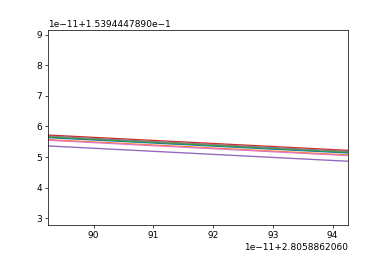

In [55]:
%matplotlib notebook
#%matplotlib inline

plt.scatter(mt_load['t_f'], mt_load['0'])
plt.plot(mt_load['t_f'], mt_load['1'])
plt.plot(mt_load['t_f'], mt_load['2'])
plt.plot(mt_load['t_f'], mt_load['3'])
plt.plot(mt_load['t_f'], mt_load['4'])

#plt.plot(mt_load['t_f'], mt_load['100'])
#plt.plot(mt_load['t_f'], mt_load['200'])
#plt.plot(mt_load['t_f'], mt_load['300'])
#plt.plot(mt_load['t_f'], mt_load['400'])
#plt.scatter(mt_load['t_f'], mt_load['500'])

plt.plot(mt_load['t_f'], mt_load['1000'])
plt.plot(mt_load['t_f'], mt_load['2000'])
plt.plot(mt_load['t_f'], mt_load['3000'])
plt.plot(mt_load['t_f'], mt_load['4000'])
plt.scatter(mt_load['t_f'], mt_load['5000'])

plt.show()


In [ ]:
i=0

for col in mt_load[0:9999]:
    tamanos= mt_load[col].values()

## OPCIONAL CONVERTIR EL DICCIONARIO EN ARRAY

## CALCULAR $m_t$ CON $\rho$ VARIABLE

In [ ]:
sizes_v = np.linspace(5e-9, 1000.e-9, 11)
#relaxivities = np.array([3.41e-6, 4.4e-6, 9.79e-6, 12.36e-6, 18.9e-6, 25.44e-6, 26e-6, 50.e-6])
relaxivities = np.array([4.4e-6, 9.79e-6, 18.9e-6, 26.e-6, 50.e-6])
T2_v = np.zeros((len(relaxivities), len(sizes_v)))

for j, relaxivity in enumerate(relaxivities):
    for i, size in enumerate(sizes_v):
        mesh1, meshfn1 = mesh_circ1(size)
        T2_v[j,i] = T2_signal1(mesh1, meshfn1, relaxivity)

**GRAFICA**

In [ ]:
with plt.style.context('seaborn'):
    fig, ax = plt.subplots(figsize= (16./1.5, 9./1.5))
    for j, relaxivity in enumerate(relaxivities):
        plt.plot(1.e9*sizes_v, 1.e3*T2_v[j],)
        
    #plt.title('$T_2^*$ contra tamaño de poro', fontsize= 'x-large')
    plt.xlabel('d (nm)', fontsize= 'large')
    plt.ylabel('$T_2^* (ms)$'+' '*17, fontsize= 'large', rotation = 'horizontal')
    plt.legend(((r'$\rho = 4.4 \ \mu m/s,\,\,\, Eagle\,\,\,Ford\,\,\,Shale$ (Jiang, 2013)'), 
                (r'$\rho = 9.79 \ \mu m/s,\,\,\, Longmaxi\,\,\,Shale$ (Peiqiang, 2019)'),
               (r'$\rho = 18.9 \ \mu m/s,\,\,\, Barnett\,\,\,Shale$ (Zhang, 2016)'), 
                (r'$\rho = 26.0 \ \mu m/s,\,\,\, Longmaxi\,\,\,Shale$ (Li, 2016)'),
               (r'$\rho = 50.0 \ \mu m/s,\,\,\, Eagle\,\,\,Ford\,\,\,Shale$ (Sondergeld, 2010)')))
    
    #plt.legend()
    
    plt.show()